# Forest Cover Deep Learning Model

In this project, we will take raw, non-scaled and non-preprocessed, data
from the US Geological Survery (USGS) and the US Forest Service (USFS).

The USFS Region 2 cartographic data is details
 forest cover type in a 30x30 meter cell, and has the following covertypes:
- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

Independent variables were from the USGS and USFS and are arranged in binary columns of data.
It contains qualitative independent variables e.g. wilderness areas and soil type.

Overall, the data encompasses four wilderness areas in the Roosevelt National Forest
in Colorado. These areas are comprised of forests with minimal human-caused disturbances,
which is lets us focus on change as a result of the environment, rather than forest management practices.

## Objectives
- Develop classifiers for this classification problem.
- Utilize TensorFlow (tf) with Keras in the build.
- Tune the hyperparameters and optimize performance of the model.

### Imports

We'll be using pandas, numpy, sklearn, tensorflow, and matplotlib, seaborn, and sweetviz for graphing.

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sweetviz as sv

First we'll suppress verbose logging from tf.

In [2]:
# Disable warnings
tf.get_logger().setLevel('ERROR')

Then we'll check for GPU availability and run off that if possible.

In [3]:
# disable logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

# checks for GPU and CUDA, if not available defaults to CPU.
try:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    if len(tf.config.list_physical_devices('GPU')) < 1:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    
except: 
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'



## Helper Functions

Let's define some helper functions! We need to accomplish the following:
- Clean our data
- Construct our model
- Plot out our data/models

We'll clean our data, ensuring that it is normalized. Let's also split it into training and test sets.

In [4]:
def clean_data(fresh_df):
    '''
    Prepare data the data for ML/DL
    - separates features from class variables
    - splits into training and testing dataset
    - scales the numerical data

    param: a dataframe of the input data
    output: x_train_normalized, x_test_normalized, y_train, y_test
    '''

    # getting the values from the df
    fresh_data = fresh_df.values
    # grabbing all rows and columns into X, y
    x, y = fresh_data[:, :-1], fresh_data[:, -1]

    # Split into train and test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

    # normalizing the data with StandardScaler
    scaler = StandardScaler()
    x_train_normalized = scaler.fit_transform(x_train)
    x_test_normalized = scaler.transform(x_test)

    return x_train_normalized, x_test_normalized, y_train, y_test

Now we can construct our model.

In [5]:
def construct_model(num_features):
    '''
    Build the model architecture (and compile it).
    input: the number of features
    output: Keras object
    '''
    classifier = keras.Sequential()

    # adding the input layer
    # defining a depth of 64 with relu activation
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    # adding dropout layers to prevent over-fitting
    classifier.add(layers.Dropout(0.3))

    # adding the hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
    # adding dropout layers to prevent over-fitting
    classifier.add(layers.Dropout(0.3))

    # adding the output layer
    classifier.add(layers.Dense(8, activation='softmax'))

    # compiling the model, using adam, sparse_categorical_crossentropy (because ints), and accuracy metrics
    classifier.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return classifier

Finally, we can look at our metrics!
We define our confusion matrix and heatmap plot here.

In [6]:
def heatmap_plot(class_names, y_pred, y_test):
    '''
    Creates a confusion matrix and plots it as a heatmap.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    '''
    # making the matrix
    matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    # using seaborn to plot the heatmap of the matrix
    heatmap = sns.heatmap(
        matrix,
        fmt='g',
        cmap='Blues',
        annot=True,
        ax=ax
    )
    # setting the labels and ticks
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

    # Saving the heatmap to a file in base directory
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

And our accuracy vs. loss history plot here.

In [7]:
def history_plot(history, param):
    """
    Shows model performance over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Vval'], loc='upper left')
        plt.show()

    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper right')
        plt.show()

## Implementing Our Model
Now that we have our helpers defined, let's run our model.

In [8]:
def main():
    # bringing in the data and creating a df
    infile = 'cover_data.csv'
    df = pd.read_csv(infile)

    # Exploratory Data Analysis (EDA)
    my_report = sv.analyze(df)
    my_report.show_html()

    # creating our cols and features
    cols = df.columns.tolist()
    features, label = cols[:-1], cols[-1]

    # cleaning up our data
    x_train, x_test, y_train, y_test = clean_data(df)

    # Building the DL model
    n_features = len(features)
    model = construct_model(n_features)

    print("Summary report of Keras classifier:")
    model.summary()


    num_epochs = 100
    batch_size = 1024

    # early stopping to make sure we don't overrun
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)

    # fitting our model
    history = model.fit(x_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1
                        )

    # plotting our accuracy and loss
    history_plot(history, 'acc')
    history_plot(history, 'loss')

    # scoring our model
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(x_test)

    # converting the predictions into discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))

    # plotting the heatmap
    heatmap_plot(class_names, y_pred, y_test)

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Summary report of Keras classifier:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3520      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 5,864
Trainable params: 5,864
Non-trainable p

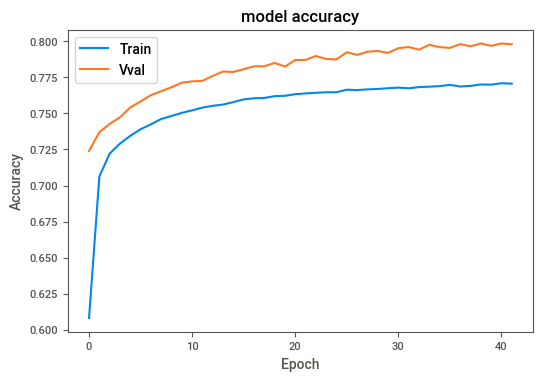

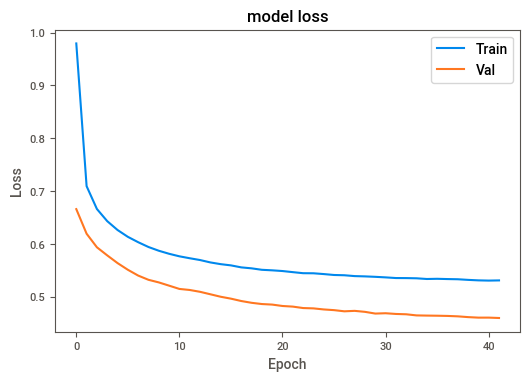

Test loss: 0.462579403759833
Test accuracy: 0.7981033325195312
                   precision    recall  f1-score   support

       Spruce/Fir       0.81      0.75      0.78     42368
   Lodgepole Pine       0.80      0.87      0.83     56661
   Ponderosa Pine       0.73      0.88      0.80      7151
Cottonwood/Willow       0.78      0.56      0.65       549
            Aspen       0.81      0.19      0.31      1899
      Douglas-fir       0.69      0.41      0.51      3473
        Krummholz       0.84      0.77      0.81      4102

         accuracy                           0.80    116203
        macro avg       0.78      0.63      0.67    116203
     weighted avg       0.80      0.80      0.79    116203



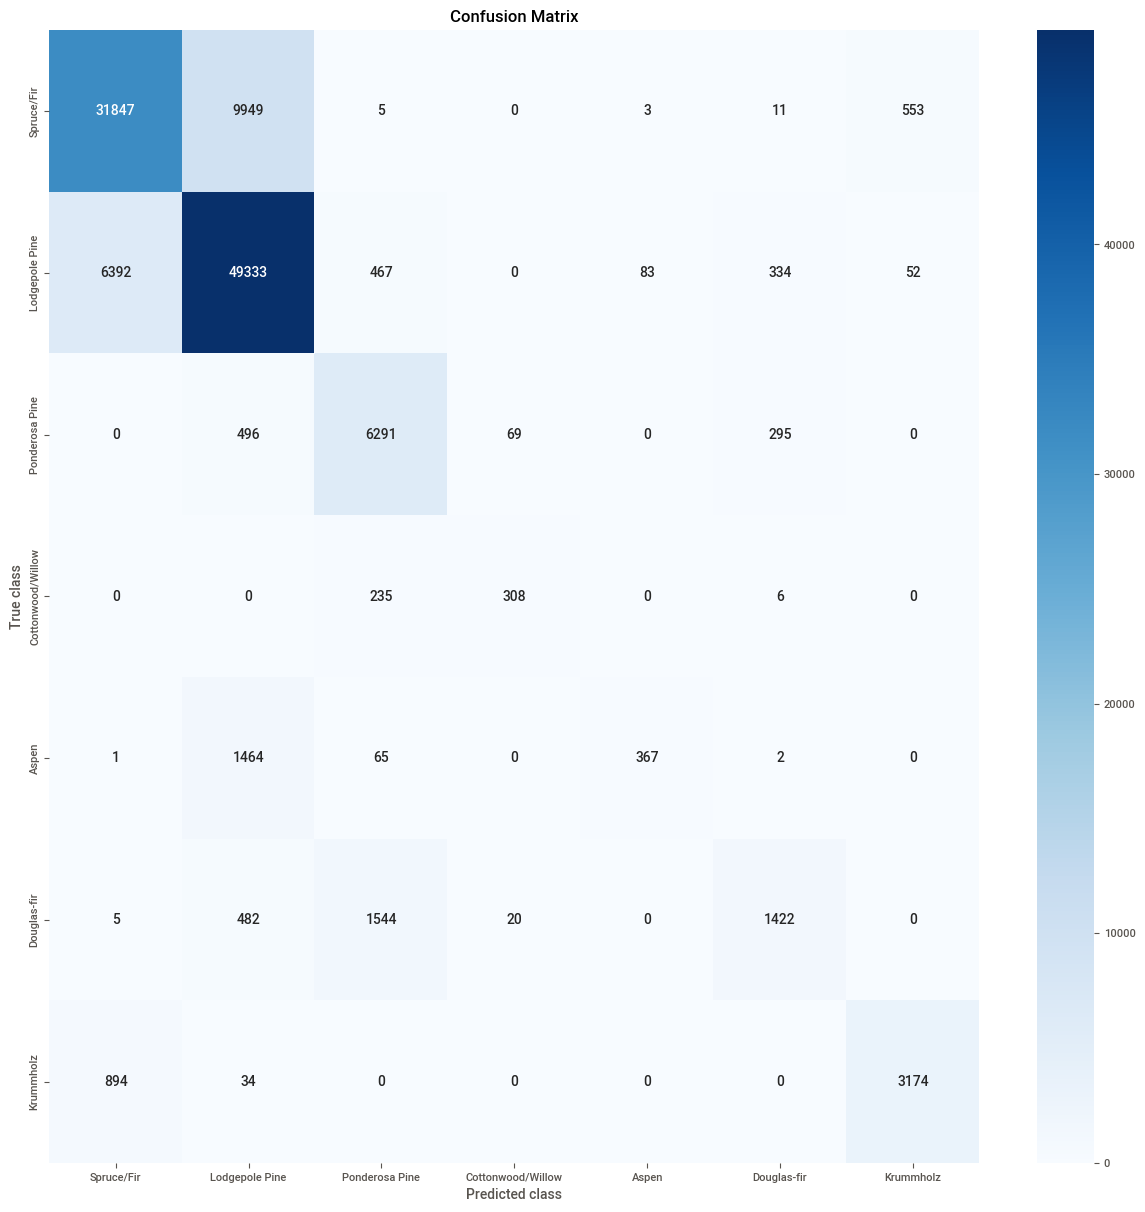

In [9]:
if __name__ == '__main__':
    main()

## Conclusion
In our heatmap of Predictions vs. True Values, the diagonal line shows how many correct predictions we correctly made.
The darker the square the greater proportion of our guesses were correct.
Other cells show how many incorrect assumptions we made.

Other than `Spruce/Fir` and `Lodgepole Pine`, we had a large percentage of mis-classifications.

## Further Research

To better our model, we could potentially explore the following:
- Check the number of observations in proportion to each covertype.
    - Imbalances in the set would affect our classification.
    - We could solve this by adjusting our sample sizes and taking subsets from each covertype, as well as proportioned randomization.

- Resampling the data.
    - Our outcome may be due to our stratification biasing our training inputs. As above, downsampling is one option.

- Investigate further how each area is distributed, with regards to covertype.
    - We could use correlations, proportions, scatterplots to identify and visualize this.
    - We could also investigator potential collinear variables and what effects this would have on our model.

- Use a performance metric other than raw model 'accuracy', as imbalanced data can skew it's reliability.
    - Other metrics (e.g. F1-score, Precision/Recall) can be used to overcome this.

- Verify the integrity of the data.
    - Perhaps our data includes inconsistencies, noise, or errors that would bias our model.
    - Consultation with analysts proficient in this domain would be advisable, in achieve the most accurate outcome.

#### Data Sources
Data was provided by the [USGS]() and [USFS]().